In [ ]:
!pip install praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.7 MB 8.2 MB/s 


In [ ]:
import glob
import numpy as np
import pandas as pd
import parselmouth

from parselmouth.praat import call
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# This is the function to measure voice pitch
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    

    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [ ]:
def runPCA(df):
    #Z-score the Jitter and Shimmer measurements
    features = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    #y = df.loc[:,['target']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    x = x[~np.isnan(x).any(axis=1), :]
    #PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    principalDf
    return principalDf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create svm classifier with and without PCA

In [ ]:
def create_voice_df_pd(path, csv_name):

  mean_F0_list = []
  sd_F0_list = []
  hnr_list = []
  localJitter_list = []
  localabsoluteJitter_list = []
  rapJitter_list = []
  ppq5Jitter_list = []
  ddpJitter_list = []
  localShimmer_list = []
  localdbShimmer_list = []
  apq3Shimmer_list = []
  aqpq5Shimmer_list = []
  apq11Shimmer_list = []
  ddaShimmer_list = []
  class_list = []

  for wave_file in glob.glob(path):
      sound = parselmouth.Sound(wave_file)
      (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, 
      rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, 
      apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
      class_list.append(1)
      mean_F0_list.append(meanF0) # make a mean F0 list
      sd_F0_list.append(stdevF0) # make a sd F0 list
      hnr_list.append(hnr)
      localJitter_list.append(localJitter)
      localabsoluteJitter_list.append(localabsoluteJitter)
      rapJitter_list.append(rapJitter)
      ppq5Jitter_list.append(ppq5Jitter)
      ddpJitter_list.append(ddpJitter)
      localShimmer_list.append(localShimmer)
      localdbShimmer_list.append(localdbShimmer)
      apq3Shimmer_list.append(apq3Shimmer)
      aqpq5Shimmer_list.append(aqpq5Shimmer)
      apq11Shimmer_list.append(apq11Shimmer)
      ddaShimmer_list.append(ddaShimmer)
      

  col = ['class','meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer']

  df = pd.DataFrame(np.column_stack([class_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, 
                                   localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list, 
                                   localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list]),
                               columns= col)  #add these lists to pandas in the right order
  

  pcaData = runPCA(df)

  for column in col:
    df[column] = df[column].astype(float)

  df = pd.concat([df, pcaData], axis=1)

  # Write out the updated dataframe
  df.to_csv(csv_name, index=False)

In [ ]:
def create_voice_df_control(path, csv_name):

  mean_F0_list = []
  sd_F0_list = []
  hnr_list = []
  localJitter_list = []
  localabsoluteJitter_list = []
  rapJitter_list = []
  ppq5Jitter_list = []
  ddpJitter_list = []
  localShimmer_list = []
  localdbShimmer_list = []
  apq3Shimmer_list = []
  aqpq5Shimmer_list = []
  apq11Shimmer_list = []
  ddaShimmer_list = []
  class_list = []

  for wave_file in glob.glob(path):
      sound = parselmouth.Sound(wave_file)
      (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, 
      rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, 
      apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
      class_list.append(0)
      mean_F0_list.append(meanF0) # make a mean F0 list
      sd_F0_list.append(stdevF0) # make a sd F0 list
      hnr_list.append(hnr)
      localJitter_list.append(localJitter)
      localabsoluteJitter_list.append(localabsoluteJitter)
      rapJitter_list.append(rapJitter)
      ppq5Jitter_list.append(ppq5Jitter)
      ddpJitter_list.append(ddpJitter)
      localShimmer_list.append(localShimmer)
      localdbShimmer_list.append(localdbShimmer)
      apq3Shimmer_list.append(apq3Shimmer)
      aqpq5Shimmer_list.append(aqpq5Shimmer)
      apq11Shimmer_list.append(apq11Shimmer)
      ddaShimmer_list.append(ddaShimmer)
      

  col = ['class','meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer']

  df = pd.DataFrame(np.column_stack([class_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, 
                                   localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list, 
                                   localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list]),
                               columns= col)  #add these lists to pandas in the right order
  

  pcaData = runPCA(df)

  for column in col:
    df[column] = df[column].astype(float)

  df = pd.concat([df, pcaData], axis=1)

  # Write out the updated dataframe
  df.to_csv(csv_name, index=False)

In [ ]:
create_voice_df_pd("/content/drive/MyDrive/pd thesis/Voice Dataset PD/PD_Ahh/train_pd/*.wav","processed_results_pd_train.csv")
create_voice_df_pd("/content/drive/MyDrive/pd thesis/Voice Dataset PD/PD_Ahh/test_pd/*.wav","processed_results_pd_test.csv")
create_voice_df_pd("/content/drive/MyDrive/pd thesis/Voice Dataset PD/PD_Ahh/val_pd/*.wav","processed_results_pd_val.csv")
create_voice_df_control("/content/drive/MyDrive/pd thesis/Voice Dataset PD/Control_Ahh/train_control/*.wav","processed_results_control_train.csv")
create_voice_df_control("/content/drive/MyDrive/pd thesis/Voice Dataset PD/Control_Ahh/test_control/*.wav","processed_results_control_test.csv")
create_voice_df_control("/content/drive/MyDrive/pd thesis/Voice Dataset PD/Control_Ahh/val_control/*.wav","processed_results_control_val.csv")

In [ ]:
df_pd_train = pd.read_csv('/content/processed_results_pd_train.csv')
df_pd_test = pd.read_csv('/content/processed_results_pd_test.csv')
df_pd_val = pd.read_csv('/content/processed_results_pd_val.csv')
df_control_train = pd.read_csv('/content/processed_results_control_train.csv')
df_control_test = pd.read_csv('/content/processed_results_control_test.csv')
df_control_val = pd.read_csv('/content/processed_results_control_val.csv')

In [ ]:
# add distribution plot

In [ ]:
print(df_pd_train.shape)
print(df_pd_test.shape)
print(df_pd_val.shape)
print(df_control_train.shape)
print(df_control_test.shape)
print(df_control_val.shape)

(479, 17)
(154, 17)
(124, 17)
(321, 17)
(101, 17)
(81, 17)


In [ ]:
df_train = pd.concat([df_pd_train, df_control_train])
df_test = pd.concat([df_pd_test, df_control_test])
df_val = pd.concat([df_pd_val, df_control_val])

In [ ]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)
df_val = df_val.dropna(axis=0)

In [ ]:
df_train.shape

(800, 17)

In [ ]:
df_test.shape

(255, 17)

In [ ]:
df_val.shape

(205, 17)

In [ ]:
df_all = pd.concat([df_train, df_test, df_val])

In [ ]:
df_all.shape

(1260, 17)

In [ ]:
df_all.head(5)

,class,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,1.0,189.088916,3.990279,13.466446,0.006928,0.000037,0.003832,0.003358,0.011497,0.065623,0.616980,0.030216,0.041237,0.063723,0.090649,-1.195954,0.667658
1,1.0,188.796500,31.434496,10.491261,0.017505,0.000093,0.010276,0.010198,0.030828,0.156068,1.491076,0.087692,0.089090,0.110107,0.263075,3.785803,-0.286111
2,1.0,96.844896,2.503975,9.899803,0.005324,0.000055,0.001792,0.003289,0.005376,0.092861,0.831764,0.044285,0.065870,0.094909,0.132856,-0.270264,-0.497295
3,1.0,208.303922,5.064979,14.500400,0.004067,0.000020,0.001952,0.002136,0.005855,0.062181,0.586280,0.029675,0.036710,0.066497,0.089025,-1.706200,0.236647
4,1.0,176.888144,45.494505,7.977118,0.021342,0.000121,0.011068,0.010703,0.033204,0.166758,1.476880,0.088192,0.099249,0.157150,0.264577,4.622162,-0.323187


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

c_arr = [0,1]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


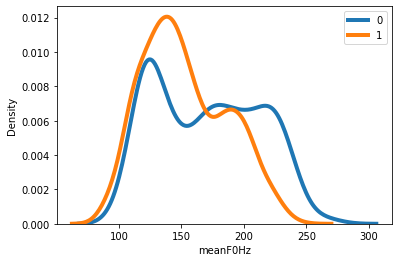

In [ ]:
for c in c_arr:

    subset = df_all[df_all['class'] == c]
    
    # Draw the density plot
    sns.distplot(subset['meanF0Hz'], hist=False, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label = c)
    
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


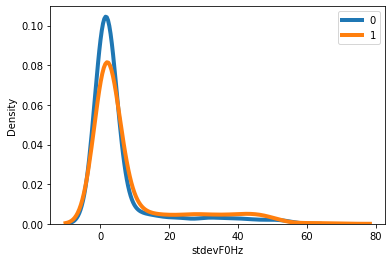

In [ ]:
for c in c_arr:

    subset = df_all[df_all['class'] == c]
    
    # Draw the density plot
    sns.distplot(subset['stdevF0Hz'], hist=False, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label = c)
    
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


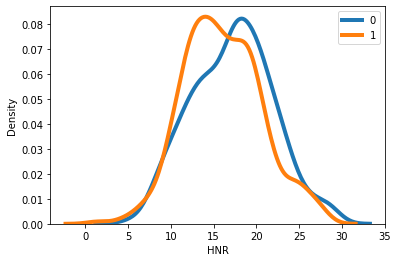

In [ ]:
for c in c_arr:

    subset = df_all[df_all['class'] == c]
    
    # Draw the density plot
    sns.distplot(subset['HNR'], hist=False, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label = c)
    
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


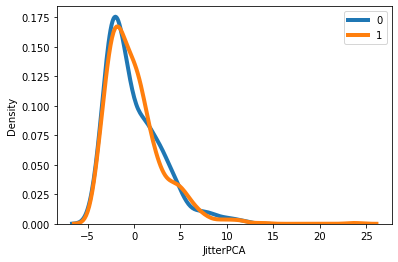

In [ ]:
for c in c_arr:

    subset = df_all[df_all['class'] == c]
    

    sns.distplot(subset['JitterPCA'], hist=False, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label = c)
    
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


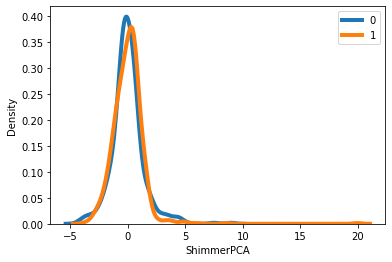

In [ ]:
for c in c_arr:

    subset = df_all[df_all['class'] == c]
    
    # Draw the density plot
    sns.distplot(subset['ShimmerPCA'], hist=False, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label = c)
    
plt.legend()

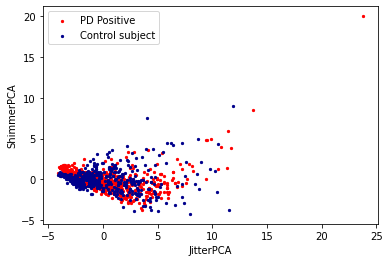

In [ ]:
ax = df_all[df_all['class'] == 1].plot(kind='scatter', x = 'JitterPCA',y = 'ShimmerPCA', color = 'Red', marker = '.', label = 'PD Positive');
df_all[df_all['class']==0].plot(kind='scatter', x = 'JitterPCA',y = 'ShimmerPCA', color = 'DarkBlue', marker = '.', label = 'Control subject', ax = ax);
plt.show()

In [ ]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df_all['HNR'], df_all['JitterPCA'], df_all['ShimmerPCA'])
threedee.set_xlabel('HNR')
threedee.set_ylabel('JitterPCA')
threedee.set_zlabel('ShimmerPCA')
plt.show()

In [ ]:
x_train = df_train[['HNR','JitterPCA','ShimmerPCA']].copy()
y_train = df_train['class']

In [ ]:
x_test = df_test[['HNR','JitterPCA','ShimmerPCA']].copy()
y_test = df_test['class']

In [ ]:
x_val = df_val[['HNR','JitterPCA','ShimmerPCA']].copy()
y_val = df_val['class']

In [ ]:
x_train.head(5)

,HNR,JitterPCA,ShimmerPCA
0,13.466446,-1.195954,0.667658
1,10.491261,3.785803,-0.286111
2,9.899803,-0.270264,-0.497295
3,14.500400,-1.706200,0.236647
4,7.977118,4.622162,-0.323187


# SVM Time

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC()
clf.fit(x_train,y_train)

SVC()

In [ ]:
yhat = clf.predict(x_val)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cfmx = confusion_matrix(y_val,yhat)
print(cfmx)
print(classification_report(y_val,yhat))

[[  0  81]
 [  2 122]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        81
         1.0       0.60      0.98      0.75       124

    accuracy                           0.60       205
   macro avg       0.30      0.49      0.37       205
weighted avg       0.36      0.60      0.45       205



Confusion matrix, without normalization
[[  0  81]
 [  2 122]]


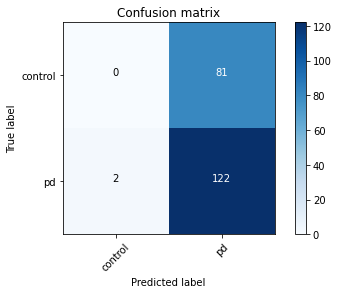

In [ ]:
plt.figure()
plot_confusion_matrix(cfmx, classes = ['control','pd'])

#Fine-tuning parameters

In [ ]:
#gamma = 'score'
#C = 733000

In [ ]:
C_range = 1000 + (2**np.arange(1,25))

C_range

In [ ]:
from sklearn.model_selection import GridSearchCV
C_range = 320000 + (1000*np.arange(0,10))
#C_range = [300000,400000,500000,600000,700000,800000,900000,1000000,2000000,3000000,4000000]
#C_range = [100000,200000,500000,1000000, 5000000,10000000]
#C_range = 100000 + (500000 * np.arange(0,20))
#C_range = 10. ** np.arange(-3,8)
#C_range = 2000 + (10 * np.arange(1,200))
#C_range = 2000 + (50 * np.arange(0,10))
#gamma_range = (10**(-3)) * np.arange(1,100)
#gamma_range = 10. ** np.arange(-5, 4)

#for i in gamm_arr:
  #gamma_range = np.append(gamma_range,i)

#C = 701000

#C = 10**5
#gamma = 10**(-3)

#param_grid = dict(gamma=gamma_range, C=C_range)
param_grid = dict(C=C_range)
#param_grid = {'C' : [1,10,100,1000,100000,100000]}
#gamma_range = ['scale','auto']
#param_grid = dict(gamma=gamma_range)

#param_grid = {'gamma' : ['scale','auto']}

grid_search = GridSearchCV(estimator = svm.SVC(probability=True),
                           param_grid = param_grid,
                           verbose = 3,
                           cv = 3,
                           n_jobs = -1)

grid_search = grid_search.fit(x_train,y_train)

# print best parameter after tuning 
print(grid_search.best_params_) 
grid_predictions = grid_search.predict(x_val) 
   
# print classification report 
print(classification_report(y_val, grid_predictions)) 


Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'C': 326000}
              precision    recall  f1-score   support

         0.0       0.41      0.44      0.43        81
         1.0       0.62      0.58      0.60       124

    accuracy                           0.53       205
   macro avg       0.51      0.51      0.51       205
weighted avg       0.53      0.53      0.53       205



Confusion matrix, without normalization
[[36 45]
 [52 72]]


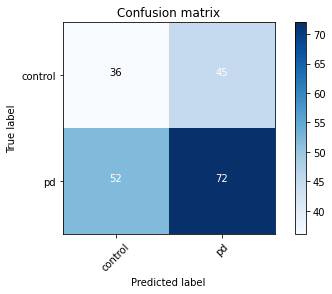

In [ ]:
cnf_gridCV = confusion_matrix(y_val, grid_predictions)

plt.figure()
plot_confusion_matrix(cnf_gridCV, classes = ['control','pd'])

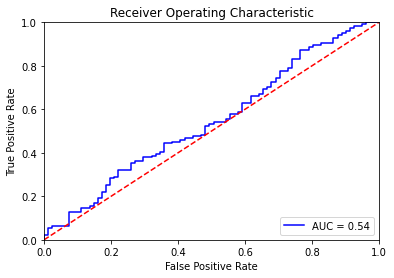

In [ ]:
from sklearn import metrics
# add roc curve
y_val_prob = grid_search.predict_proba(x_val)

preds_svm = y_val_prob[:,1]
#preds_tree = y_tree_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds_svm)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
y_test_predict = grid_search.predict(x_test)

In [ ]:
print(classification_report(y_test, y_test_predict)) 

              precision    recall  f1-score   support

         0.0       0.70      0.58      0.64       101
         1.0       0.75      0.84      0.79       154

    accuracy                           0.74       255
   macro avg       0.73      0.71      0.72       255
weighted avg       0.73      0.74      0.73       255



Confusion matrix, without normalization
[[ 59  42]
 [ 25 129]]


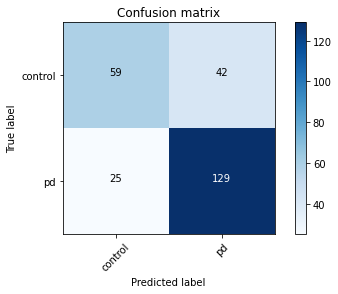

In [ ]:
cnf_test = confusion_matrix(y_test, y_test_predict)

plt.figure()
plot_confusion_matrix(cnf_test, classes = ['control','pd'])

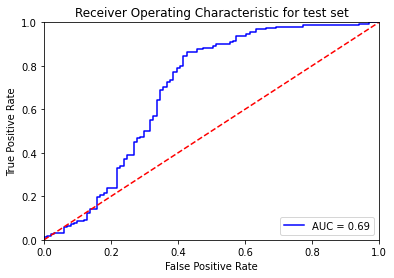

In [ ]:
y_test_prob = grid_search.predict_proba(x_test)

preds_svm_test = y_test_prob[:,1]

fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, preds_svm_test)
roc_auc_test = metrics.auc(fpr_test, tpr_test)


plt.title('Receiver Operating Characteristic for test set')
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()